In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import KFold

# Load the Food-101 dataset (train only)
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# Get the class names
class_names = info.features['label'].names[:10]  # Select the first 10 classes
num_classes = len(class_names)

# Filter the dataset to keep only the first 10 classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_dataset = dataset.filter(filter_classes)

# Define augmentation layers outside the mapping function
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# Preprocessing function with data augmentation
def preprocess_with_augmentation(image, label):
    image = tf.image.resize(image, (224, 224))
    image = augmentation_layers(image)
    image = image / 255.0  # Normalization [0,1]
    return image, label

# Convert the dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Apply preprocessing
filtered_dataset = filtered_dataset.map(preprocess_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
images, labels = dataset_to_numpy(filtered_dataset)

# KFold configuration
k = 5  # Number of folds
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store results
accuracy_per_fold = []
loss_per_fold = []
history_dicts = []


In [31]:
# Define the ResNet model
def create_model():
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base layers
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [33]:
# Training and validation with KFold
fold_no = 1
for train_idx, val_idx in kfold.split(images, labels):
    train_images, val_images = images[train_idx], images[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create the model
    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, epochs=40, validation_data=(val_images, val_labels),
                       callbacks=[
                           tf.keras.callbacks.ModelCheckpoint(filepath=f'resnet_model_fold_{fold_no}.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
                           tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
                       ])

    # Evaluate the model
    test_loss, test_acc = model.evaluate(val_images, val_labels)
    accuracy_per_fold.append(test_acc)
    loss_per_fold.append(test_loss)
    history_dicts.append(history.history)

    print(f'Fold {fold_no} - Accuracy: {test_acc * 100:.2f}% - Loss: {test_loss:.4f}')
    fold_no += 1

# Display average results
print(f'\nAverage Accuracy: {np.mean(accuracy_per_fold) * 100:.2f}%')
print(f'Average Loss: {np.mean(loss_per_fold):.4f}')

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1181 - loss: 2.4524
Epoch 1: val_loss improved from inf to 2.23809, saving model to resnet_model_fold_1.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.1182 - loss: 2.4518 - val_accuracy: 0.1593 - val_loss: 2.2381 - learning_rate: 0.0010
Epoch 2/40
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1526 - loss: 2.2620
Epoch 2: val_loss improved from 2.23809 to 2.22665, saving model to resnet_model_fold_1.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.1526 - loss: 2.2619 - val_accuracy: 0.1620 - val_loss: 2.2266 - learning_rate: 0.0010
Epoch 3/40
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1484 - loss: 2.2439
Epoch 3: val_loss did not improve from 2.22665
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1485 - loss: 2.2439 - val_accuracy: 0.1527 - val_loss: 2.2402 - learning_rate: 0.0010
Epoch 4/40
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.137

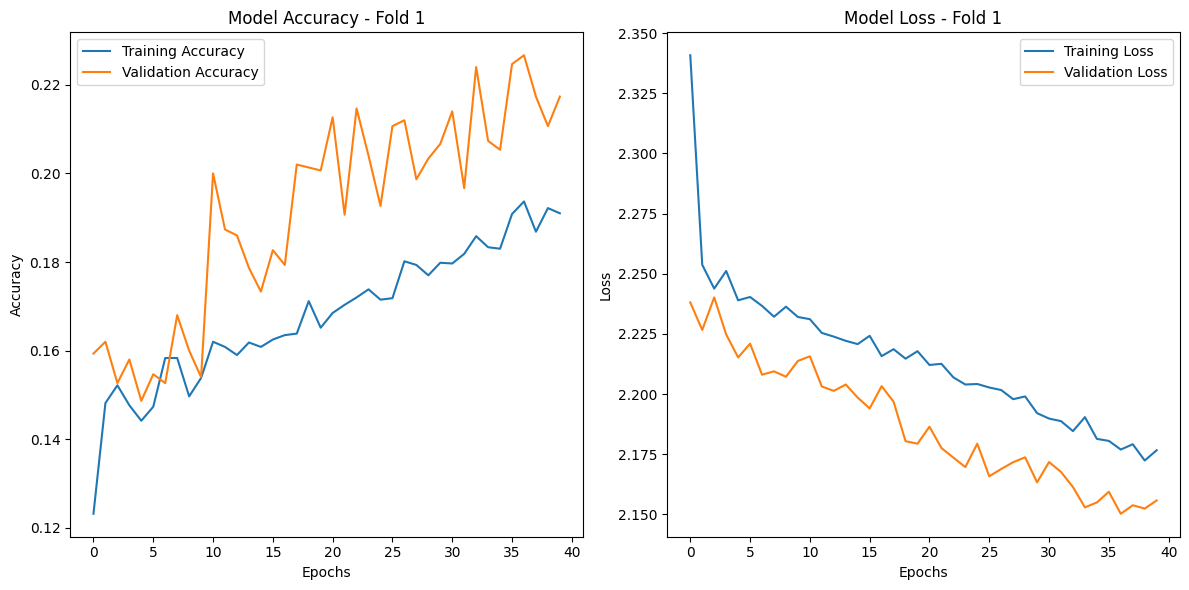

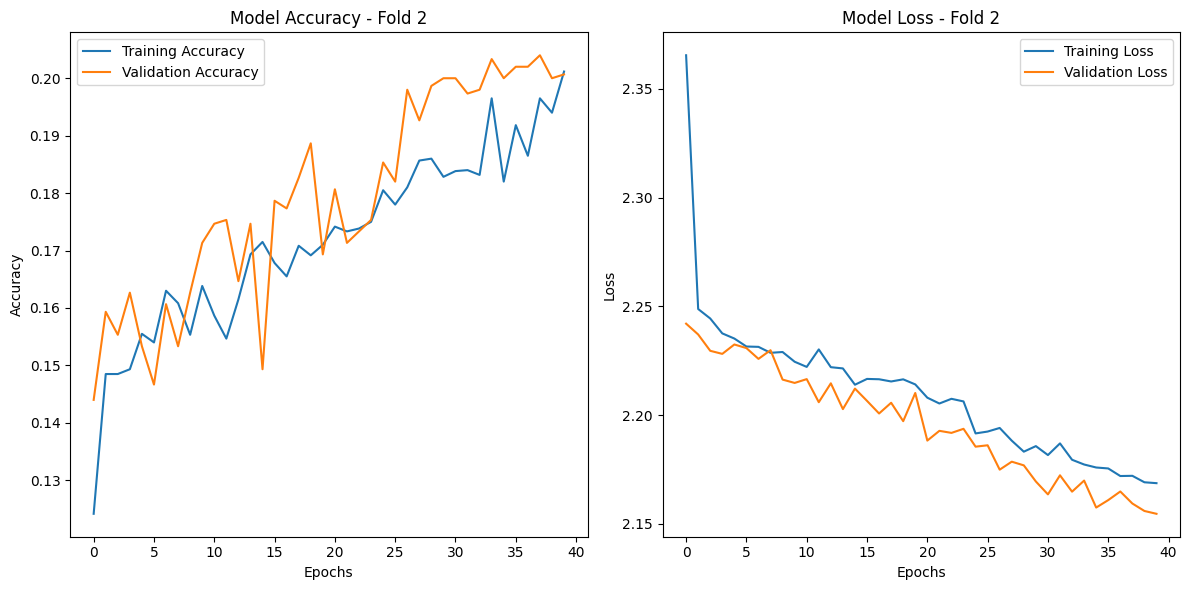

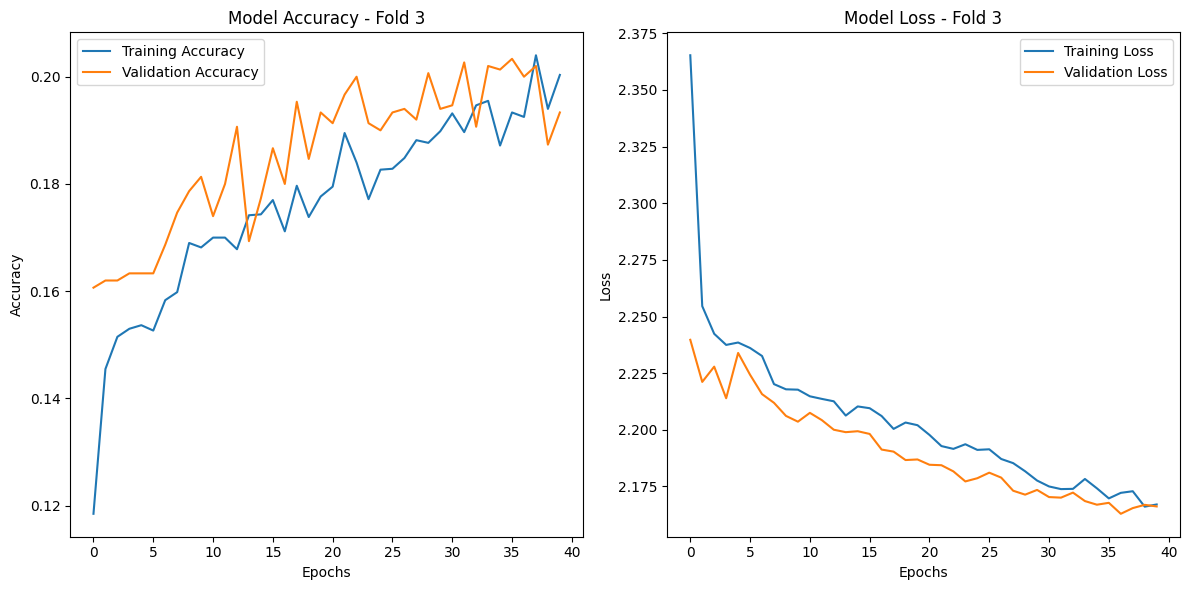

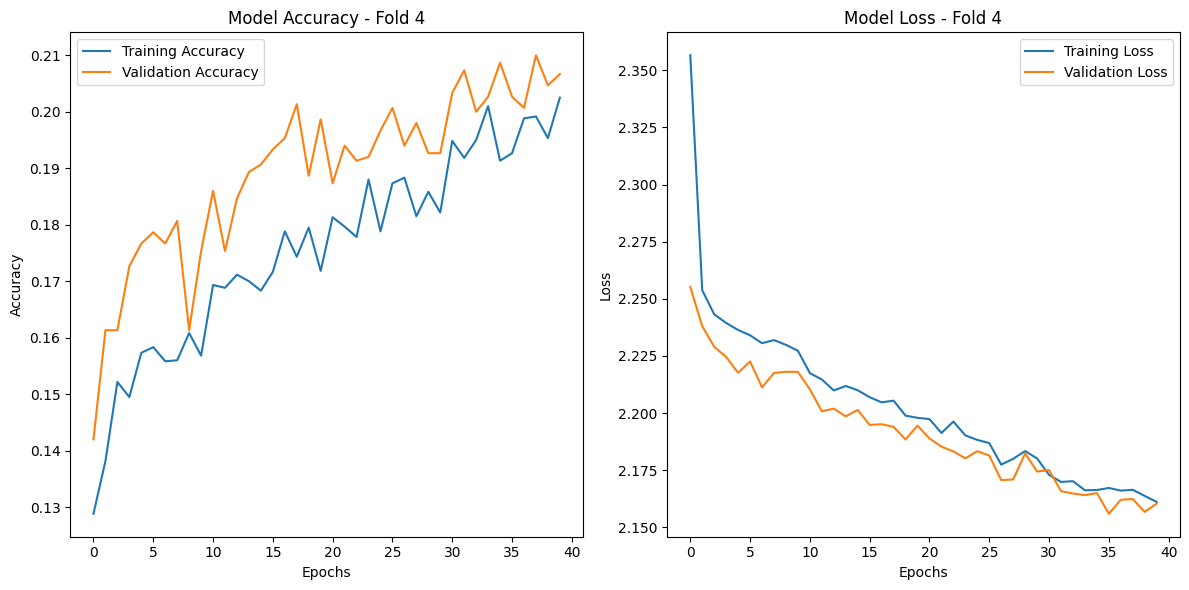

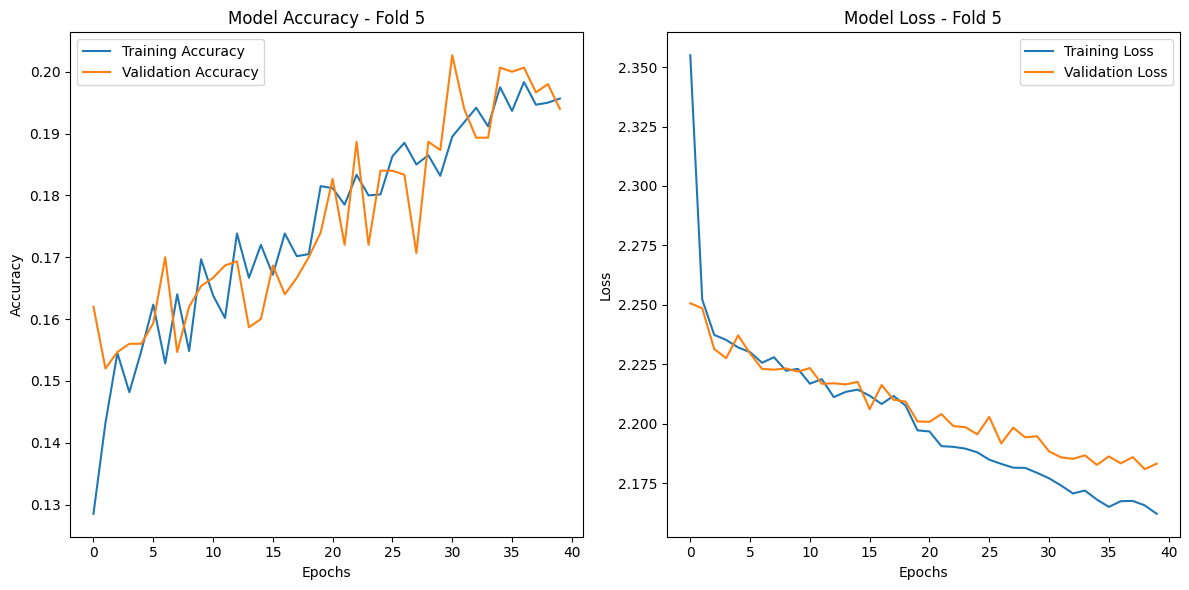

In [34]:
import matplotlib.pyplot as plt
# Plot accuracy and loss for each fold
for i, history_dict in enumerate(history_dicts):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'Model Accuracy - Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Model Loss - Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Classification report
y_pred_probs = model.predict(val_images)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Classification Report:")
print(classification_report(val_labels, y_pred, target_names=class_names, digits=4))

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step
Classification Report:
                   precision    recall  f1-score   support

        apple_pie     0.2821    0.0738    0.1170       149
   baby_back_ribs     0.1941    0.4490    0.2710       147
          baklava     0.1870    0.5679    0.2813       162
   beef_carpaccio     0.2000    0.0733    0.1073       150
     beef_tartare     0.1212    0.0745    0.0923       161
       beet_salad     0.2196    0.4610    0.2975       141
         beignets     0.2453    0.1857    0.2114       140
         bibimbap     0.1754    0.0654    0.0952       153
    bread_pudding     0.2857    0.0292    0.0530       137
breakfast_burrito     0.0000    0.0000    0.0000       160

         accuracy                         0.1980      1500
        macro avg     0.1910    0.1980    0.1526      1500
     weighted avg     0.1878    0.1980    0.1515      1500



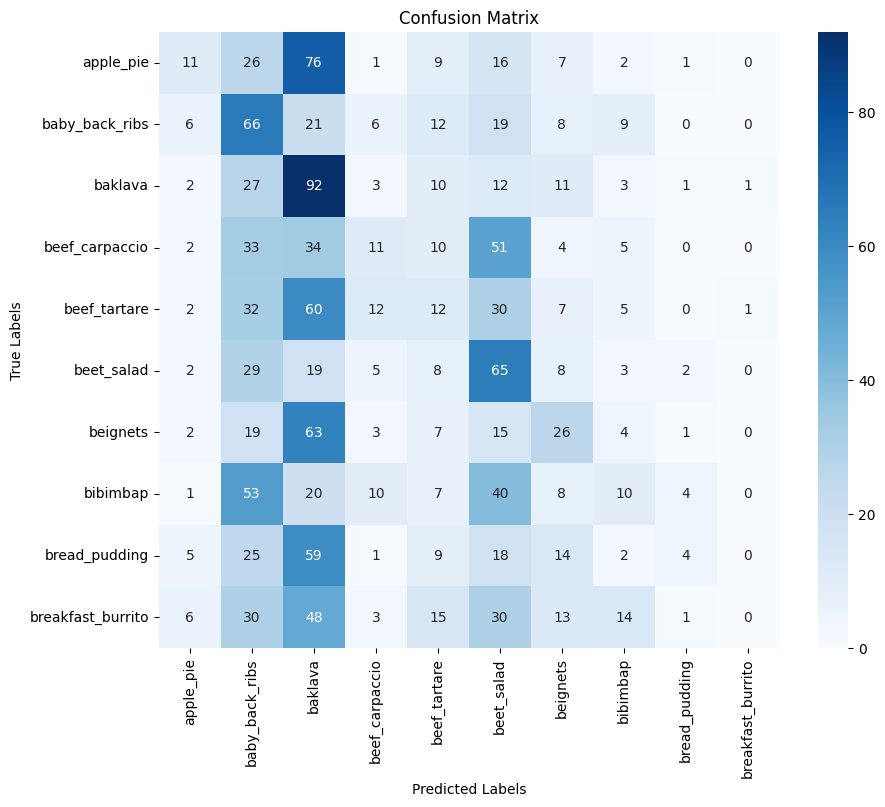

In [36]:
#confusion matrix
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()